In [3]:
import pandas as pd
import numpy as np
df=pd.read_excel("../data/数据整合cleaned去除异常值.xlsx").drop('负荷率平均值(%)', axis=1)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.metrics import root_mean_squared_error,mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
# 设置中文字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [4]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## 划分训练集和测试集

In [5]:
# 数据集中包含特征和目标变量，要把他们划分开
# 特征矩阵，不包含目标变量。df中去除碳排放强度列以外的列就是特征。
X1 = df.drop('碳排放强度', axis=1).drop('日期', axis=1).drop('机组', axis=1)
# df的碳排放强度列是目标变量
y1 = df['碳排放强度']
from sklearn.model_selection import train_test_split
#划分训练集和测试集，将数据集分为训练集（80%）和测试集（20%）
# test_size=0.2 这个参数就代表20%的样本做测试集
# random_state参数设置随机数种子，保证每次切分运行结果一致。
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

## 线性回归

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error,mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
# 创建线性回归模型
linear_model = LinearRegression()
# 拟合模型
linear_model.fit(X1_train, y1_train)
# 在测试集上进行预测
linear_y1_pred = linear_model.predict(X1_test)

linear_mse = mean_squared_error(y1_test, linear_y1_pred)
linear_rmse = np.sqrt(linear_mse)  # Calculating RMSE
linear_mae = mean_absolute_error(y1_test, linear_y1_pred)
linear_mape = mean_absolute_percentage_error(y1_test, linear_y1_pred)
linear_r2 = r2_score(y1_test,linear_y1_pred)

# 输出结果
print(f"linear_MSE: {linear_mse:.6f}")
print(f"linear_RMSE: {linear_rmse:.6f}")
print(f"linear_MAE: {linear_mae:.6f}")
print(f"linear_MAPE: {linear_mape*100:.6f}")
print(f"linear_R Square: {linear_r2:.6f}")
print(f"回归系数: {linear_model.coef_}")
print(f"截距: {linear_model.intercept_}")

linear_MSE: 2144.646546
linear_RMSE: 46.310329
linear_MAE: 31.755413
linear_MAPE: 2.590330
linear_R Square: 0.882198
回归系数: [ -3.35409798   8.26664227 -18.04271444  16.99375066  25.15523883
  -1.69577389  -5.41589293  21.61474555  16.19385366  18.08172495
  18.42202931  19.75265    -16.53306298   8.5635319 ]
截距: -9765.134570571528


In [7]:
def plot_compare_line(predictions):
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 计算线性回归拟合系数
    z = np.polyfit(y1_test, predictions, 1)  # 线性拟合
    p = np.poly1d(z)  # 得到拟合的多项式函数
    # 计算拟合值
    y_fit = p(y1_test)
    # 计算残差
    residuals = predictions - y_fit
    # 计算标准误差
    std_err = np.std(residuals)
    # 计算95%置信区间
    confidence_interval = 1.96 * std_err  # 95%置信区间对应的倍数是1.96
    # 使用 pandas DataFrame 排序
    data = pd.DataFrame({'y_test': y1_test, 'y_pred': predictions, 'y_fit': y_fit})
    # 按 'y_test' 升序排序
    data_sorted = data.sort_values(by='y_test')
    # 提取排序后的值
    sorted_y_test = data_sorted['y_test'].values
    sorted_y_pred = data_sorted['y_pred'].values
    sorted_y_fit = data_sorted['y_fit'].values
    # 绘制散点图，x轴为实际值，y轴为预测值
    plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.6, edgecolor='k', label='Data point')
    # 绘制拟合线
    plt.plot(sorted_y_test, sorted_y_fit, color='orange', alpha=0.6, label=f"Fit line\n$R^2$ = {r2_score(y1_test, predictions):.2f}")
    # 绘制95%置信区间阴影区域
    plt.fill_between(sorted_y_test, sorted_y_fit - confidence_interval, sorted_y_fit + confidence_interval, color='orange', alpha=0.1, label='95% Confidence interval')
    # 添加y=x的参考线，用于比较预测值与实际值的吻合度
    max_val = max(sorted_y_test.max(), sorted_y_pred.max())  # 找到最大值，确保参考线绘制完整
    min_val = min(sorted_y_test.min(), sorted_y_pred.min())  # 找到最小值
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')  # 画出y=x的对角线
    # 图表标题和标签
    plt.title("Comparison of model predictions with real values", fontsize=14)
    plt.xlabel("Real values of CEI / (g/kWh)", fontsize=14)
    plt.ylabel("Predictions of CEI / (g/kWh)", fontsize=14)
    # 显示图例
    plt.legend(fontsize=12)
    # 显示图表
    plt.tight_layout()
    # plt.savefig('预测值与实际值的吻合度_XGB.png', dpi=2000, bbox_inches='tight')  # Save as PNG with 500 dpi
    plt.show()

In [8]:
def plot_compare(predictions):
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 绘制test data预测值和真实值
    plt.figure(figsize=(9, 5))
    plt.plot(predictions, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
    plt.plot(y1_test.values, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
    # 绘制test data的预测值和真实值
    plt.scatter(range(len(predictions)), predictions, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
    plt.scatter(range(len(y1_test.values)), y1_test.values, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
    # 创建自定义的图例（线+点）
    line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
    line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")
    
    # 显示图例
    plt.legend(handles=[line1, line2], fontsize=12.5)
    plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
    plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')
    
    # 显示图表
    plt.tight_layout()  # 调整布局，确保所有元素不重叠
    # plt.savefig("xgb1.png",dpi=500,bbox_inches='tight')
    plt.show()

## 3.1 随机森林（Random Forest，RF）

In [9]:
correlation_matrix = df.drop('日期', axis=1).drop('机组', axis=1).corr()#除日期、机组列

rf_MSE: 3110.127898
rf_RMSE: 55.768521
rf_MAE: 43.043188
rf_MAPE: 3.462986
rf_R Square: 0.829166


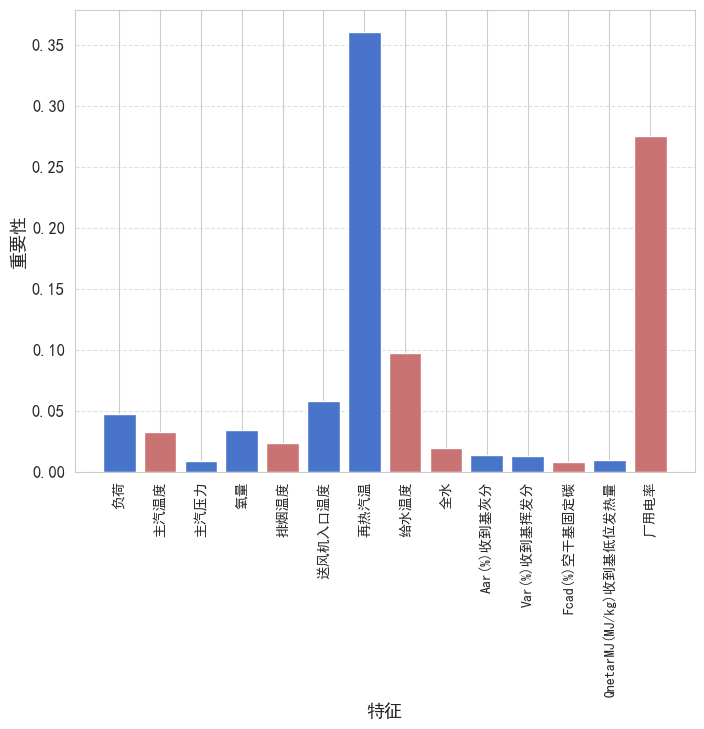

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error,mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
rf_model = RandomForestRegressor(n_jobs=28,max_depth=10,n_estimators=40)
# rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X1_train, y1_train)
rf_y1_pred = rf_model.predict(X1_test)

rf_mse = mean_squared_error(y1_test, rf_y1_pred)
rf_rmse = np.sqrt(rf_mse)  # Calculating RMSE
rf_mae = mean_absolute_error(y1_test, rf_y1_pred)
rf_mape = mean_absolute_percentage_error(y1_test, rf_y1_pred)
rf_r2 = r2_score(y1_test, rf_y1_pred)

feature_importances = rf_model.feature_importances_
feature_names = X1.columns
# 计算特征与目标变量的相关系数
correlations =correlation_matrix['碳排放强度'].drop('碳排放强度')
# 可视化特征重要性和相关性
plt.figure(figsize=(8, 6))
plt.bar(feature_names, feature_importances, color=np.where(correlations > 0, '#CA7373', '#4874CB'))
plt.xticks(fontsize=10, rotation=90,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.xlabel("特征",fontsize = 13,fontweight='bold')
plt.ylabel("重要性",fontsize = 13,fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.savefig("rf1_corr.png",dpi=500,bbox_inches='tight')
print(f"rf_MSE: {rf_mse:.6f}")
print(f"rf_RMSE: {rf_rmse:.6f}")
print(f"rf_MAE: {rf_mae:.6f}")
print(f"rf_MAPE: {rf_mape*100:.6f}")
print(f"rf_R Square: {rf_r2:.6f}")

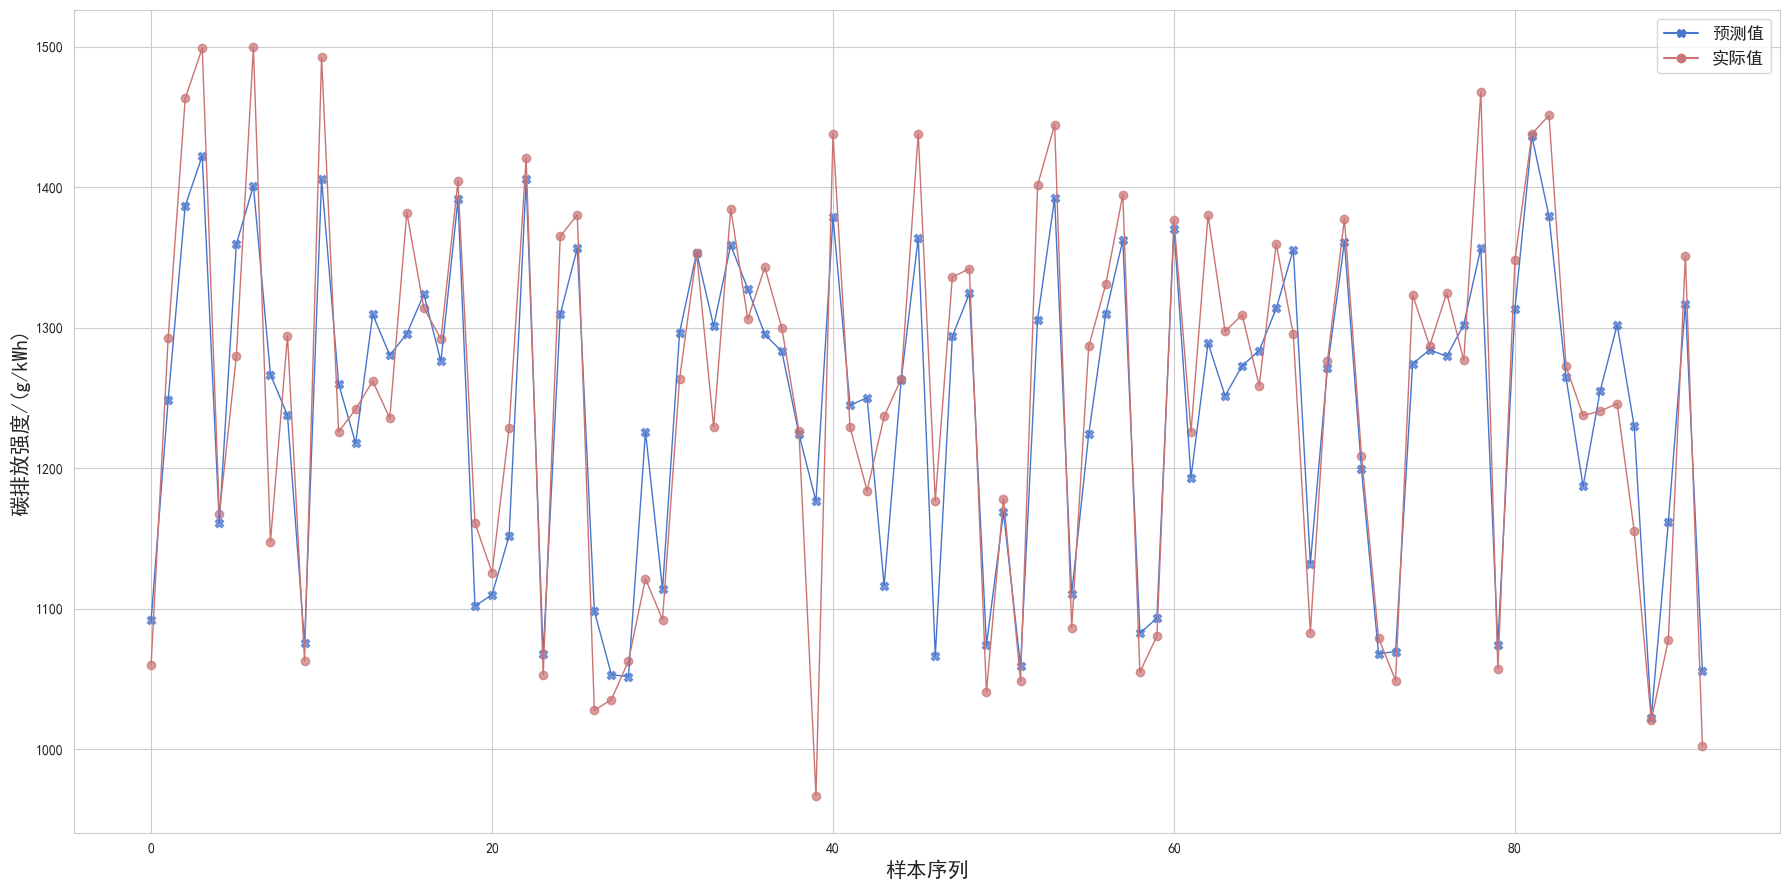

In [11]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines  # 导入 mlines
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(rf_y1_pred, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
# 绘制test data的预测值和真实值
plt.scatter(range(len(rf_y1_pred)), rf_y1_pred, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
plt.scatter(range(len(y1_test)), y1_test.values, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
# 创建自定义的图例（线+点）
line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")

# 显示图例
plt.legend(handles=[line1, line2], fontsize=12.5)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("rf1.png",dpi=500,bbox_inches='tight')
plt.show()

## 3.2 XGBoost

In [12]:
from xgboost import XGBRegressor
# 初始化XGBoost回归器
xgb_model = XGBRegressor(
    n_estimators=72,        # 树的数量
    max_depth=4,             # 树的最大深度
    learning_rate=0.1,       # 学习率
    subsample=0.8,           # 每棵树使用的样本比例
    colsample_bytree=0.8,    # 每棵树使用的特征比例
    # random_state=42
)
# 训练模型
xgb_model.fit(X1_train, y1_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=72, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) Arial.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 33655 (\N{CJK UNIFIED IDEOGRAPH-8377}) missing from font(s) Arial.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) Arial.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 27773 (\N{CJK UNIFIED IDEOGRAPH-6C7D}) missing from font(s) Arial.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) Arial.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph

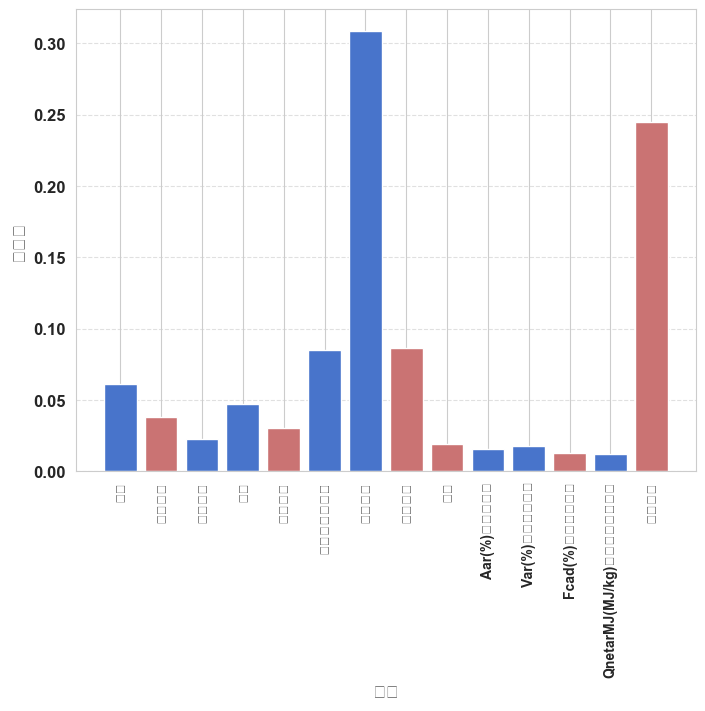

In [13]:
from matplotlib.font_manager import FontProperties
from sklearn.metrics import root_mean_squared_error,mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
# Predict on the test set
xgb_y1_pred =  xgb_model.predict(X1_test)
# Evaluate the model
xgb_mse = mean_squared_error(y1_test, xgb_y1_pred)
xgb_rmse = np.sqrt(xgb_mse)  # Calculating RMSE
xgb_mae = mean_absolute_error(y1_test, xgb_y1_pred)
xgb_mape = mean_absolute_percentage_error(y1_test, xgb_y1_pred)
xgb_r2 = r2_score(y1_test, xgb_y1_pred)
# 特征重要性
feature_importances = xgb_model.feature_importances_
# 可视化特征重要性和相关性
plt.figure(figsize=(8, 6))
plt.bar(feature_names, feature_importances, color=np.where(correlations > 0, '#CA7373', '#4874CB'))
plt.xticks(fontsize=10, rotation=90,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.xlabel("特征",fontsize = 13)
plt.ylabel("重要性",fontsize = 13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.savefig("xgb1_corr.png",dpi=500,bbox_inches='tight')

C:\Users\97112\AppData\Local\Temp\ipykernel_34804\3860325967.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = correlations[sorted_idx]  # 排序后的相关性
D:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Program Files\Python310

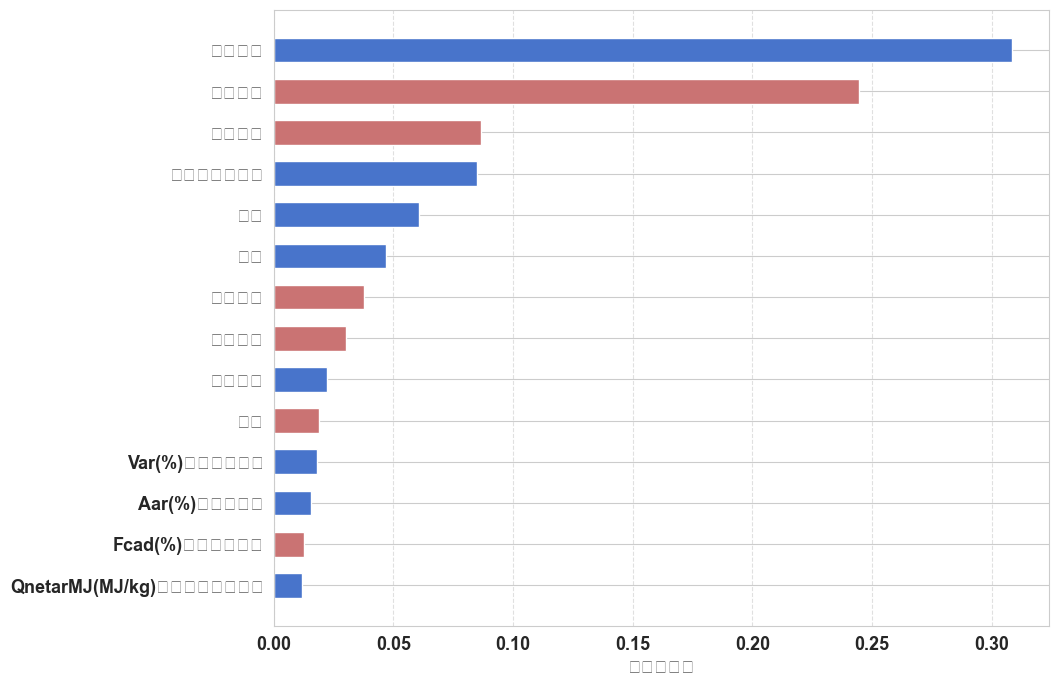

xgb_MSE: 2728.644264
xgb_RMSE: 52.236427
xgb_MAE: 38.187695
xgb_MAPE: 3.078045
xgb_R Square: 0.850120


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 假设correlations数组已存在，它表示每个特征的相关性
# 按特征重要性排序
sorted_idx = np.argsort(feature_importances)  # 获取按重要性排序的索引
sorted_feature_names = np.array(feature_names)[sorted_idx]  # 排序后的特征名
sorted_feature_importances = feature_importances[sorted_idx]  # 排序后的特征重要性
sorted_correlations = correlations[sorted_idx]  # 排序后的相关性


# 可视化特征重要性和正反相关性
plt.figure(figsize=(10, 8))
bars = plt.barh(sorted_feature_names, sorted_feature_importances,height = 0.6,
                color=np.where(sorted_correlations > 0, '#CA7373', '#4874CB'))

# 设置y轴标签的字体粗细
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("特征重要性", fontsize=13, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.savefig("feature.png",dpi=1200,bbox_inches='tight')
plt.show()
print(f"xgb_MSE: {xgb_mse:.6f}")
print(f"xgb_RMSE: {xgb_rmse:.6f}")
print(f"xgb_MAE: {xgb_mae:.6f}")
print(f"xgb_MAPE: {xgb_mape*100:.6f}")
print(f"xgb_R Square: {xgb_r2:.6f}")

C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1922149670.py:19: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) Arial.
  plt.tight_layout()  # 调整布局，确保所有元素不重叠
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1922149670.py:19: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) Arial.
  plt.tight_layout()  # 调整布局，确保所有元素不重叠
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1922149670.py:19: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) Arial.
  plt.tight_layout()  # 调整布局，确保所有元素不重叠
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1922149670.py:19: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) Arial.
  plt.tight_layout()  # 调整布局，确保所有元素不重叠
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1922149670.py:19: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) Arial.
  plt.tight_layout()  # 调整布局，确保所有元素不重叠
C:\Users\97112\AppData\Local\Temp\i

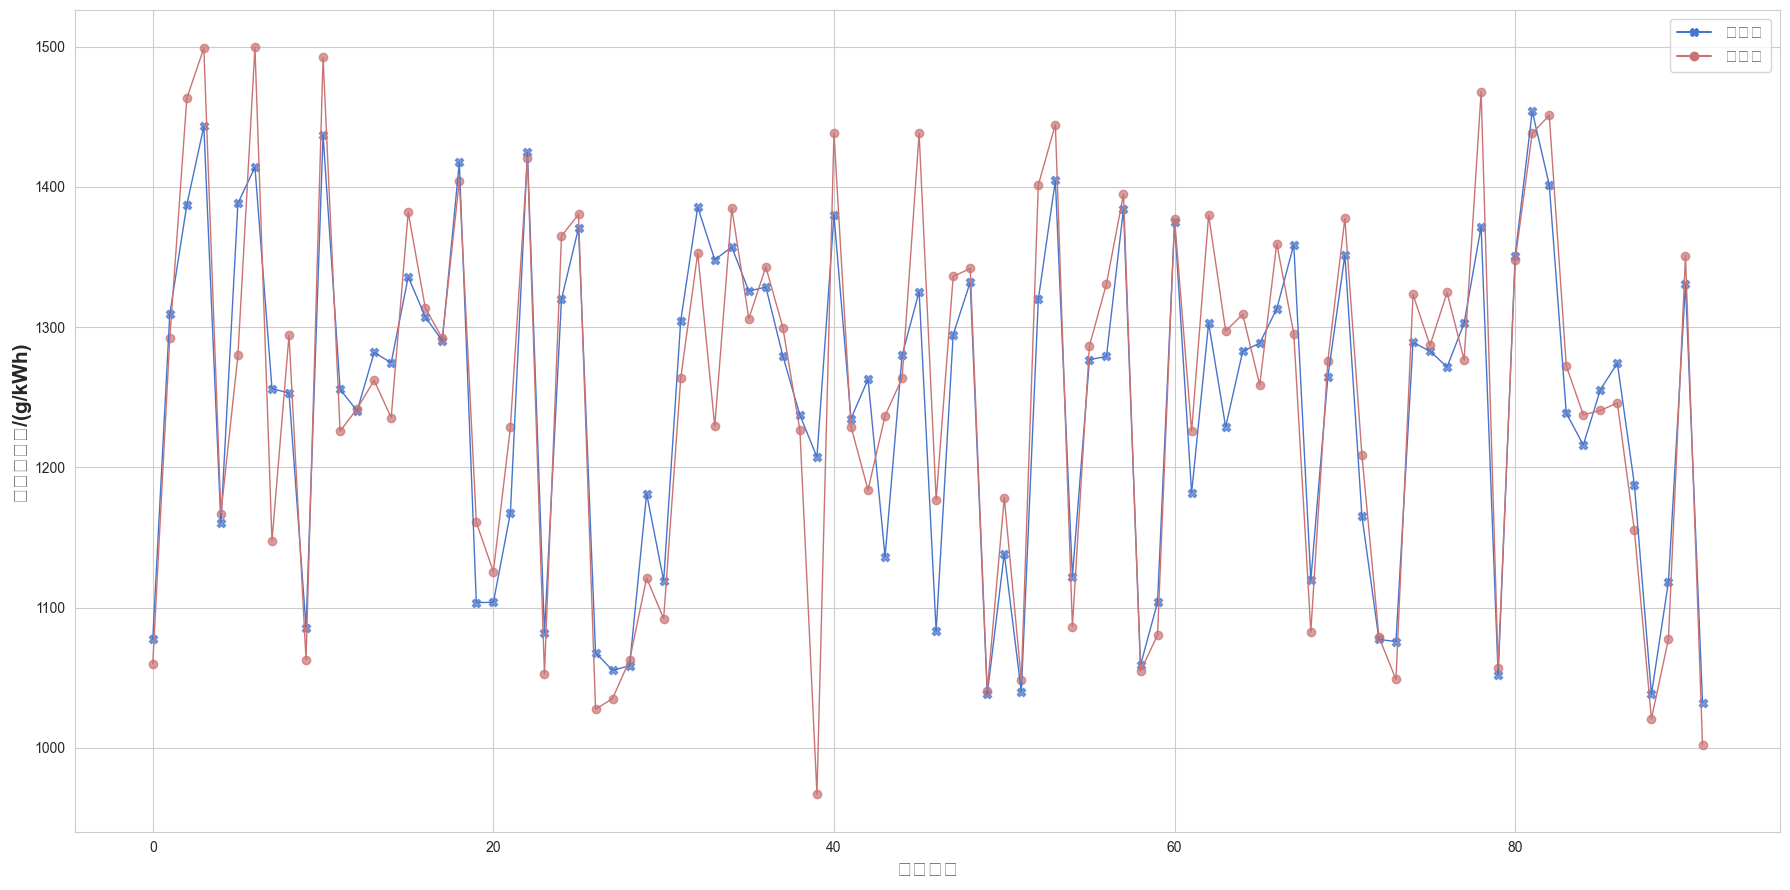

In [15]:
#xgb 机组1 测试集
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(xgb_y1_pred, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
# 绘制test data的预测值和真实值
plt.scatter(range(len(xgb_y1_pred)), xgb_y1_pred, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
plt.scatter(range(len(y1_test)), y1_test.values, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
# 创建自定义的图例（线+点）
line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")

# 显示图例
plt.legend(handles=[line1, line2], fontsize=12.5)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("xgb1.png",dpi=500,bbox_inches='tight')
plt.show()


C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1404658370.py:25: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1404658370.py:25: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1404658370.py:25: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1404658370.py:25: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1404658370.py:25: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1404658370.py:25: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E})

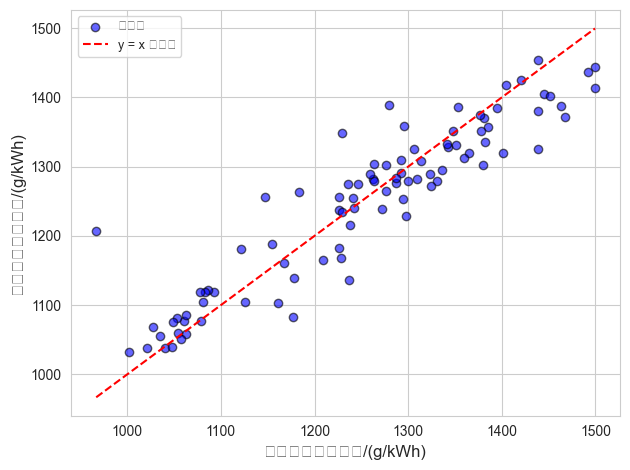

In [16]:
# Evaluate the model
xgb_mse = mean_squared_error(y1_test, xgb_y1_pred)
xgb_rmse = np.sqrt(xgb_mse)  # Calculating RMSE
xgb_mae = mean_absolute_error(y1_test, xgb_y1_pred)
xgb_mape = mean_absolute_percentage_error(y1_test, xgb_y1_pred)
xgb_r2 = r2_score(y1_test, xgb_y1_pred)

# 绘制散点图，x轴为实际值，y轴为预测值
plt.scatter(y1_test, xgb_y1_pred, color='blue', alpha=0.6, edgecolor='k', label='数据点')

# 添加y=x的参考线，用于比较预测值与实际值的吻合度
max_val = max(y1_test.max(), xgb_y1_pred.max())  # 找到最大值，确保参考线绘制完整
min_val = min(y1_test.min(), xgb_y1_pred.min())  # 找到最小值
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x 参考线')  # 画出y=x的对角线

# 图表标题和标签

plt.xlabel("碳排放强度实际值/(g/kWh)", fontsize=12)
plt.ylabel("碳排放强度预测值/(g/kWh)", fontsize=12)

# 显示图例
plt.legend(fontsize=9)

# 显示图表
plt.tight_layout()
#plt.savefig('预测值与实际值的吻合度.png', dpi=500, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()


In [17]:
'''Index(['日期', '机组', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风机入口温度', '再热汽温', '给水温度',
       '全水', 'Aar(%)收到基灰分', 'Var(%)收到基挥发分', 'Fcad(%)空干基固定碳',
       'QnetarMJ(MJ/kg)收到基低位发热量', '厂用电率', '负荷率平均值(%)', '碳排放强度'],
      dtype='object')'''
# 给水温度 负荷率平均值(%) 主汽压力 QnetarMJ(MJ/kg)收到基低位发热量 再热汽温

"Index(['日期', '机组', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风机入口温度', '再热汽温', '给水温度',\n       '全水', 'Aar(%)收到基灰分', 'Var(%)收到基挥发分', 'Fcad(%)空干基固定碳',\n       'QnetarMJ(MJ/kg)收到基低位发热量', '厂用电率', '负荷率平均值(%)', '碳排放强度'],\n      dtype='object')"

In [18]:
def pianYiLai(f1,f2,s1,s2):
    from sklearn.inspection import PartialDependenceDisplay
    import warnings
    warnings.filterwarnings("ignore")
    t2_features3 = [f1, f2,(f1,f2)]
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
    # 生成双向部分依赖图
    disp = PartialDependenceDisplay.from_estimator(xgb_model, X1[0:300], t2_features3)
    
    disp.axes_.ravel()[0].set_ylabel('Partial dependency/(g/kWh)', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[2].set_ylabel(s2, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[0].set_xlabel(s1, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[1].set_xlabel(s2, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    disp.axes_.ravel()[2].set_xlabel(s1, fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
    plt.subplots_adjust(wspace=0.7)
    
    # Save the plot to an image file
    #plt.savefig('partial_dependence_plot3.png', dpi=1000, bbox_inches='tight')  # Save as PNG with 500 dpi
    plt.show()

In [19]:
'''pianYiLai('负荷率平均值(%)','给水温度','负荷率平均值(%)','给水温度(°C)')
pianYiLai('负荷率平均值(%)','主汽压力','负荷率平均值(%)','主汽压力/Pa')
pianYiLai('负荷率平均值(%)','QnetarMJ(MJ/kg)收到基低位发热量','负荷率平均值(%)','收到基低位发热量(MJ/kg)')
pianYiLai('负荷率平均值(%)','再热汽温','负荷率平均值(%)','再热汽温/°C')
pianYiLai('负荷率','送风温度','LR(%)','AST(℃)')
pianYiLai('负荷率','排烟温度','LR(%)','FGT(℃)')
pianYiLai('负荷率','全水','LR(%)','TM(%)')'''

"pianYiLai('负荷率平均值(%)','给水温度','负荷率平均值(%)','给水温度(°C)')\npianYiLai('负荷率平均值(%)','主汽压力','负荷率平均值(%)','主汽压力/Pa')\npianYiLai('负荷率平均值(%)','QnetarMJ(MJ/kg)收到基低位发热量','负荷率平均值(%)','收到基低位发热量(MJ/kg)')\npianYiLai('负荷率平均值(%)','再热汽温','负荷率平均值(%)','再热汽温/°C')\npianYiLai('负荷率','送风温度','LR(%)','AST(℃)')\npianYiLai('负荷率','排烟温度','LR(%)','FGT(℃)')\npianYiLai('负荷率','全水','LR(%)','TM(%)')"

## 关系图

In [20]:
X1_test.columns

Index(['负荷', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风机入口温度', '再热汽温', '给水温度', '全水',
       'Aar(%)收到基灰分', 'Var(%)收到基挥发分', 'Fcad(%)空干基固定碳',
       'QnetarMJ(MJ/kg)收到基低位发热量', '厂用电率'],
      dtype='object')

C:\Users\97112\AppData\Local\Temp\ipykernel_34804\2965964792.py:28: UserWarning: Glyph 27687 (\N{CJK UNIFIED IDEOGRAPH-6C27}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\2965964792.py:28: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\2965964792.py:28: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\2965964792.py:28: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\2965964792.py:28: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\2965964792.py:28: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A})

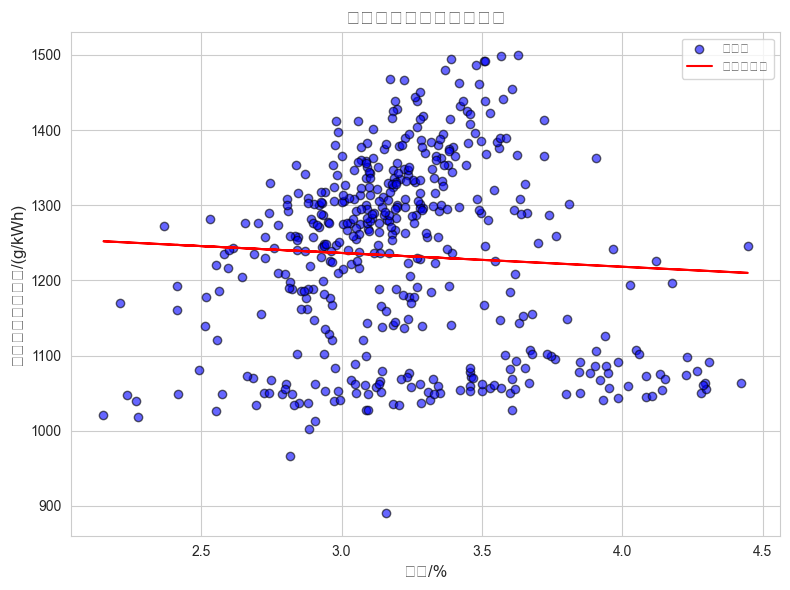

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 假设 X1 和 y1 是包含氧量和碳排放强度的列

# 创建一个单独的图
plt.figure(figsize=(8, 6))

# 绘制氧量与碳排放强度的散点图
plt.scatter(X1['氧量'], y1, color='blue', alpha=0.6, edgecolor='k', label='数据点')

# 计算最佳拟合线
slope, intercept, _, _, _ = linregress(X1['氧量'], y1)

# 绘制最佳拟合线
plt.plot(X1['氧量'], slope * X1['氧量'] + intercept, color='red', label='最佳拟合线')

# 设置标签和标题
plt.xlabel("氧量/%", fontsize=12)
plt.ylabel("碳排放强度实际值/(g/kWh)", fontsize=12)
plt.title("氧量与碳排放强度的关系", fontsize=14)
plt.legend(fontsize=9)

# 设置坐标轴刻度
plt.tick_params(axis='both', which='major', labelsize=10)

# 显示图表
plt.tight_layout()

# 保存图像
# plt.savefig('氧量与碳排放强度关系.png', dpi=1200, bbox_inches='tight')  # 保存为PNG图像
plt.show()


In [22]:
'''import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1: 全水分（%） vs 碳排放强度
axs[0, 0].scatter(X1_test['全水'], y1_test, color='blue', alpha=0.6, edgecolor='k', label='数据点')
# Calculate best fit line
slope, intercept, _, _, _ = linregress(X1_test['全水'], y1_test)
axs[0, 0].plot(X1_test['全水'], slope * X1_test['全水'] + intercept, color='red', label='最佳拟合线')
axs[0, 0].set_xlabel('全水', fontsize=12)
axs[0, 0].set_ylabel("碳排放强度实际值/(g/kWh)", fontsize=12)
axs[0, 0].legend(fontsize=9)
axs[0, 0].tick_params(axis='both', which='major', labelsize=10)

# Plot 2: 送风温度 vs 碳排放强度
axs[0, 1].scatter(X1_test["排汽温度"], y1_test, color='blue', alpha=0.6, edgecolor='k', label='数据点')
# Calculate best fit line
slope, intercept, _, _, _ = linregress(X1_test["排汽温度"], y1_test)
axs[0, 1].plot(X1_test["排汽温度"], slope * X1_test["排汽温度"] + intercept, color='red', label='最佳拟合线')
axs[0, 1].set_xlabel("排汽温度/℃", fontsize=12)
axs[0, 1].set_ylabel("碳排放强度实际值/(g/kWh)", fontsize=12)
axs[0, 1].legend(fontsize=9)
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)

# Plot 3: 收到基低位发热量(kJ/kg) vs 碳排放强度
axs[1, 0].scatter(X1_test['QnetarMJ(MJ/kg)收到基低位发热量'], y1_test, color='blue', alpha=0.6, edgecolor='k', label='数据点')
# Calculate best fit line
slope, intercept, _, _, _ = linregress(X1_test['QnetarMJ(MJ/kg)收到基低位发热量'], y1_test)
axs[1, 0].plot(X1_test['QnetarMJ(MJ/kg)收到基低位发热量'], slope * X1_test['QnetarMJ(MJ/kg)收到基低位发热量'] + intercept, color='red', label='最佳拟合线')
axs[1, 0].set_xlabel('收到基低位发热量(kJ/kg)', fontsize=12)
axs[1, 0].set_ylabel("碳排放强度实际值/(g/kWh)", fontsize=12)
axs[1, 0].legend(fontsize=9)
axs[1, 0].tick_params(axis='both', which='major', labelsize=10)

# Plot 4: 负荷 vs 碳排放强度
axs[1, 1].scatter(X1_test["负荷率"], y1_test, color='blue', alpha=0.6, edgecolor='k', label='数据点')
# Calculate best fit line
slope, intercept, _, _, _ = linregress(X1_test["负荷率"], y1_test)
axs[1, 1].plot(X1_test["负荷率"], slope * X1_test["负荷率"] + intercept, color='red', label='最佳拟合线')
axs[1, 1].set_xlabel("负荷率/%", fontsize=12)
axs[1, 1].set_ylabel("碳排放强度实际值/(g/kWh)", fontsize=12)
axs[1, 1].legend(fontsize=9)
axs[1, 1].tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to make sure subplots fit well
plt.tight_layout()

# Show the combined plot
plt.show()
'''

'import matplotlib.pyplot as plt\nimport numpy as np\nfrom scipy.stats import linregress\n\n# Create a 2x2 grid of subplots\nfig, axs = plt.subplots(2, 2, figsize=(10, 8))\n\n# Plot 1: 全水分（%） vs 碳排放强度\naxs[0, 0].scatter(X1_test[\'全水\'], y1_test, color=\'blue\', alpha=0.6, edgecolor=\'k\', label=\'数据点\')\n# Calculate best fit line\nslope, intercept, _, _, _ = linregress(X1_test[\'全水\'], y1_test)\naxs[0, 0].plot(X1_test[\'全水\'], slope * X1_test[\'全水\'] + intercept, color=\'red\', label=\'最佳拟合线\')\naxs[0, 0].set_xlabel(\'全水\', fontsize=12)\naxs[0, 0].set_ylabel("碳排放强度实际值/(g/kWh)", fontsize=12)\naxs[0, 0].legend(fontsize=9)\naxs[0, 0].tick_params(axis=\'both\', which=\'major\', labelsize=10)\n\n# Plot 2: 送风温度 vs 碳排放强度\naxs[0, 1].scatter(X1_test["排汽温度"], y1_test, color=\'blue\', alpha=0.6, edgecolor=\'k\', label=\'数据点\')\n# Calculate best fit line\nslope, intercept, _, _, _ = linregress(X1_test["排汽温度"], y1_test)\naxs[0, 1].plot(X1_test["排汽温度"], slope * X1_test["排汽温度"] + intercept, color=\'r

C:\Users\97112\AppData\Local\Temp\ipykernel_34804\518332552.py:57: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\518332552.py:57: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\518332552.py:57: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\518332552.py:57: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\518332552.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\518332552.py:57: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missi

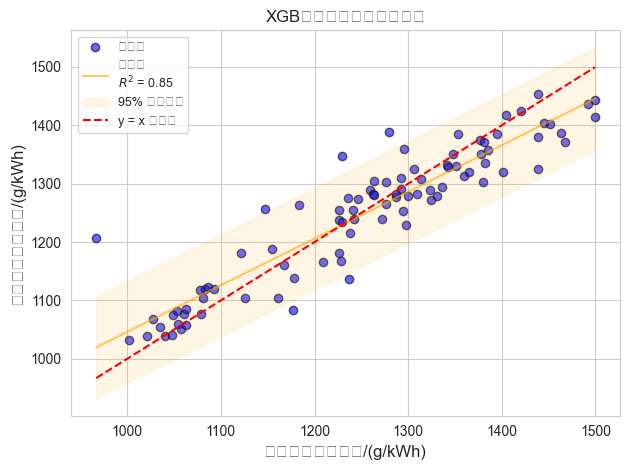

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 假设 y1_test 是实际值，xgb_y1_pred 是 XGB 模型的预测值

# 计算线性回归拟合系数
z = np.polyfit(y1_test, xgb_y1_pred, 1)  # 线性拟合
p = np.poly1d(z)  # 得到拟合的多项式函数

# 计算拟合值
y_fit = p(y1_test)

# 计算残差
residuals = xgb_y1_pred - y_fit

# 计算标准误差
std_err = np.std(residuals)

# 计算95%置信区间
confidence_interval = 1.96 * std_err  # 95%置信区间对应的倍数是1.96

# 使用 pandas DataFrame 排序
data = pd.DataFrame({'y_test': y1_test, 'y_pred': xgb_y1_pred, 'y_fit': y_fit})

# 按 'y_test' 升序排序
data_sorted = data.sort_values(by='y_test')

# 提取排序后的值
sorted_y_test = data_sorted['y_test'].values
sorted_y_pred = data_sorted['y_pred'].values
sorted_y_fit = data_sorted['y_fit'].values

# 绘制散点图，x轴为实际值，y轴为预测值
plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.6, edgecolor='k', label='数据点')

# 绘制拟合线
plt.plot(sorted_y_test, sorted_y_fit, color='orange', alpha=0.6, label=f"拟合线\n$R^2$ = {r2_score(y1_test, xgb_y1_pred):.2f}")

# 绘制95%置信区间阴影区域
plt.fill_between(sorted_y_test, sorted_y_fit - confidence_interval, sorted_y_fit + confidence_interval, color='orange', alpha=0.1, label='95% 置信区间')

# 添加y=x的参考线，用于比较预测值与实际值的吻合度
max_val = max(sorted_y_test.max(), sorted_y_pred.max())  # 找到最大值，确保参考线绘制完整
min_val = min(sorted_y_test.min(), sorted_y_pred.min())  # 找到最小值
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x 参考线')  # 画出y=x的对角线

# 图表标题和标签
plt.title("XGB模型预测与实际值比较")
plt.xlabel("碳排放强度实际值/(g/kWh)", fontsize=12)
plt.ylabel("碳排放强度预测值/(g/kWh)", fontsize=12)

# 显示图例
plt.legend(fontsize=9)

# 显示图表
plt.tight_layout()
# plt.savefig('预测值与实际值的吻合度_XGB.png', dpi=2000, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()


C:\Users\97112\AppData\Local\Temp\ipykernel_34804\696813631.py:57: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\696813631.py:57: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\696813631.py:57: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\696813631.py:57: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\696813631.py:57: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\696813631.py:57: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missi

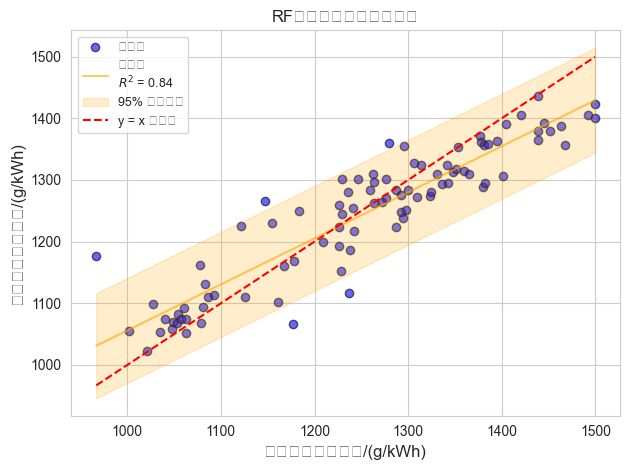

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 假设 y1_test 是实际值，rf_y1_pred 是 RF 模型的预测值

# 计算线性回归拟合系数
z = np.polyfit(y1_test, rf_y1_pred, 1)  # 线性拟合
p = np.poly1d(z)  # 得到拟合的多项式函数

# 计算拟合值
y_fit = p(y1_test)

# 计算残差
residuals = rf_y1_pred - y_fit

# 计算标准误差
std_err = np.std(residuals)

# 计算95%置信区间
confidence_interval = 1.96 * std_err  # 95%置信区间对应的倍数是1.96

# 使用 pandas DataFrame 排序
data = pd.DataFrame({'y_test': y1_test, 'y_pred': rf_y1_pred, 'y_fit': y_fit})

# 按 'y_test' 升序排序
data_sorted = data.sort_values(by='y_test')

# 提取排序后的值
sorted_y_test = data_sorted['y_test'].values
sorted_y_pred = data_sorted['y_pred'].values
sorted_y_fit = data_sorted['y_fit'].values

# 绘制散点图，x轴为实际值，y轴为预测值
plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.6, edgecolor='k', label='数据点')

# 绘制拟合线
plt.plot(sorted_y_test, sorted_y_fit, color='orange', alpha=0.6, label=f"拟合线\n$R^2$ = {np.corrcoef(sorted_y_test, sorted_y_pred)[0,1]**2:.2f}")

# 绘制95%置信区间阴影区域
plt.fill_between(sorted_y_test, sorted_y_fit - confidence_interval, sorted_y_fit + confidence_interval, color='orange', alpha=0.2, label='95% 置信区间')

# 添加y=x的参考线，用于比较预测值与实际值的吻合度
max_val = max(sorted_y_test.max(), sorted_y_pred.max())  # 找到最大值，确保参考线绘制完整
min_val = min(sorted_y_test.min(), sorted_y_pred.min())  # 找到最小值
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x 参考线')  # 画出y=x的对角线

# 图表标题和标签
plt.title("RF模型预测与实际值比较")
plt.xlabel("碳排放强度实际值/(g/kWh)", fontsize=12)
plt.ylabel("碳排放强度预测值/(g/kWh)", fontsize=12)

# 显示图例
plt.legend(fontsize=9)

# 显示图表
plt.tight_layout()
# plt.savefig('预测值与实际值的吻合度_RF_with_fit_line_and_ci_sorted.png', dpi=500, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()


C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1133160119.py:30: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1133160119.py:30: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1133160119.py:30: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1133160119.py:30: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1133160119.py:30: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\97112\AppData\Local\Temp\ipykernel_34804\1133160119.py:30: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E})

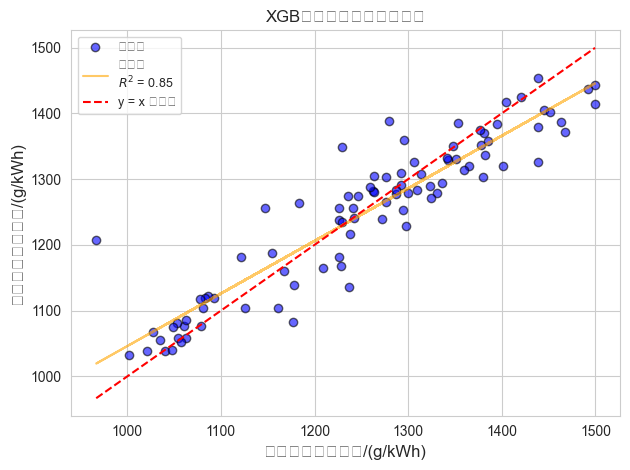

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 y1_test 是实际值，xgb_y1_pred 是XGB模型的预测值

# 绘制散点图，x轴为实际值，y轴为预测值
plt.scatter(y1_test, xgb_y1_pred, color='blue', alpha=0.6, edgecolor='k', label='数据点')

# 使用numpy.polyfit拟合线，1表示线性拟合（一次多项式）
z = np.polyfit(y1_test, xgb_y1_pred, 1)
p = np.poly1d(z)

# 绘制拟合线
plt.plot(y1_test, p(y1_test), color='orange', alpha=0.6, label=f"拟合线\n$R^2$ = {np.corrcoef(y1_test, xgb_y1_pred)[0,1]**2:.2f}")

# 添加y=x的参考线，用于比较预测值与实际值的吻合度
max_val = max(y1_test.max(), xgb_y1_pred.max())  # 找到最大值，确保参考线绘制完整
min_val = min(y1_test.min(), xgb_y1_pred.min())  # 找到最小值
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x 参考线')  # 画出y=x的对角线

# 图表标题和标签
plt.title("XGB模型预测与实际值比较")
plt.xlabel("碳排放强度实际值/(g/kWh)", fontsize=12)
plt.ylabel("碳排放强度预测值/(g/kWh)", fontsize=12)

# 显示图例
plt.legend(fontsize=9)

# 显示图表
plt.tight_layout()
# plt.savefig('预测值与实际值的吻合度_with_fit_line.png', dpi=500, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()


In [26]:
'''import shap
# Initialize the SHAP TreeExplainer with the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test dataset (or any data you want to explain)
shap_values = explainer.shap_values(X1_test)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X1_test, show=False)
# plt.savefig('shap.png', dpi=500, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()
'''

"import shap\n# Initialize the SHAP TreeExplainer with the trained XGBoost model\nexplainer = shap.TreeExplainer(xgb_model)\n\n# Compute SHAP values for the test dataset (or any data you want to explain)\nshap_values = explainer.shap_values(X1_test)\n\n# Visualize SHAP summary plot\nshap.summary_plot(shap_values, X1_test, show=False)\n# plt.savefig('shap.png', dpi=500, bbox_inches='tight')  # Save as PNG with 500 dpi\nplt.show()\n"

In [27]:
'''import shap
import matplotlib.pyplot as plt

# Initialize the SHAP TreeExplainer with the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test dataset (or any data you want to explain)
shap_values = explainer.shap_values(X1_test)

# Visualize SHAP violin plot
shap.summary_plot(shap_values, X1_test, plot_type="violin", show=False)

# Save the plot as a PNG with high resolution
# plt.savefig('shap_violin.png', dpi=1200, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()
#'#CA7373', '#4874CB'''

'import shap\nimport matplotlib.pyplot as plt\n\n# Initialize the SHAP TreeExplainer with the trained XGBoost model\nexplainer = shap.TreeExplainer(xgb_model)\n\n# Compute SHAP values for the test dataset (or any data you want to explain)\nshap_values = explainer.shap_values(X1_test)\n\n# Visualize SHAP violin plot\nshap.summary_plot(shap_values, X1_test, plot_type="violin", show=False)\n\n# Save the plot as a PNG with high resolution\n# plt.savefig(\'shap_violin.png\', dpi=1200, bbox_inches=\'tight\')  # Save as PNG with 500 dpi\nplt.show()\n#\'#CA7373\', \'#4874CB'

In [28]:
'''import shap
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the SHAP TreeExplainer with the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test dataset (or any data you want to explain)
shap_values = explainer.shap_values(X1_test)

# Create a custom colormap with two colors
colors = ['#CA7373', '#4874CB']  # Low -> high color scale
ncmap = mpl.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)

# Visualize SHAP violin plot with custom colormap
shap.summary_plot(shap_values, X1_test, plot_type="layered_violin", show=False, cmap=ncmap, max_display=12,)


fig = plt.gcf()
ax = fig.axes[-1]
ax.set_ylabel('特征值')
# ax.yaxis.label
ax.set_yticklabels(['低', '高'])

# 获取当前的坐标轴对象
ax = plt.gca()  # 获取当前的坐标轴对象
# 设置 x 轴标签（SHAP值）
ax.set_xlabel('SHAP值')  # 修改 x 轴的标签


# Save the plot as a PNG with high resolution
# plt.savefig('shap1_violin_custom_colors.png', dpi=1200, bbox_inches='tight')  # Save as PNG with 1200 dpi
plt.show()
'''

'import shap\nimport matplotlib.pyplot as plt\nimport matplotlib as mpl\nfrom sklearn.ensemble import GradientBoostingClassifier\n\n# Initialize the SHAP TreeExplainer with the trained XGBoost model\nexplainer = shap.TreeExplainer(xgb_model)\n\n# Compute SHAP values for the test dataset (or any data you want to explain)\nshap_values = explainer.shap_values(X1_test)\n\n# Create a custom colormap with two colors\ncolors = [\'#CA7373\', \'#4874CB\']  # Low -> high color scale\nncmap = mpl.colors.LinearSegmentedColormap.from_list("custom_cmap", colors)\n\n# Visualize SHAP violin plot with custom colormap\nshap.summary_plot(shap_values, X1_test, plot_type="layered_violin", show=False, cmap=ncmap, max_display=12,)\n\n\nfig = plt.gcf()\nax = fig.axes[-1]\nax.set_ylabel(\'特征值\')\n# ax.yaxis.label\nax.set_yticklabels([\'低\', \'高\'])\n\n# 获取当前的坐标轴对象\nax = plt.gca()  # 获取当前的坐标轴对象\n# 设置 x 轴标签（SHAP值）\nax.set_xlabel(\'SHAP值\')  # 修改 x 轴的标签\n\n\n# Save the plot as a PNG with high resolution\n# plt.sa

## 3.3 支持向量机

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 读取数据
data = df

# 预处理
data['日期'] = pd.to_datetime(data['日期'])

svm_X = data.drop(columns=['碳排放强度', '日期','机组'])
svm_y = data['碳排放强度']

# 特征缩放
scaler = StandardScaler()
svm_X_scaled = scaler.fit_transform(svm_X)


# 划分训练集和测试集
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_scaled, svm_y, test_size=0.2, random_state=42)

# 创建并训练SVR模型
svr_model = SVR(gamma=0.007,C=990,epsilon=0.05)
svr_model.fit(svm_X_train, svm_y_train)

# 进行预测
svm_y_pred = svr_model.predict(svm_X_test)

# 评估模型
svm_mse = mean_squared_error(svm_y_test, svm_y_pred)
svm_rmse = np.sqrt(svm_mse)
svm_mae = mean_absolute_error(svm_y_test, svm_y_pred)
svm_mape = mean_absolute_percentage_error(svm_y_test, svm_y_pred)
svm_r2 = r2_score(svm_y_test, svm_y_pred)

print(f"svm_MSE: {svm_mse:.6f}")
print(f"svm_RMSE: {svm_rmse:.6f}")
print(f"svm_MAE: {svm_mae:.6f}")
print(f"svm_MAPE: {svm_mape*100:.6f}")
print(f"svm_R Square: {svm_r2:.6f}")

svm_MSE: 2035.203718
svm_RMSE: 45.113232
svm_MAE: 30.860375
svm_MAPE: 2.513429
svm_R Square: 0.888210


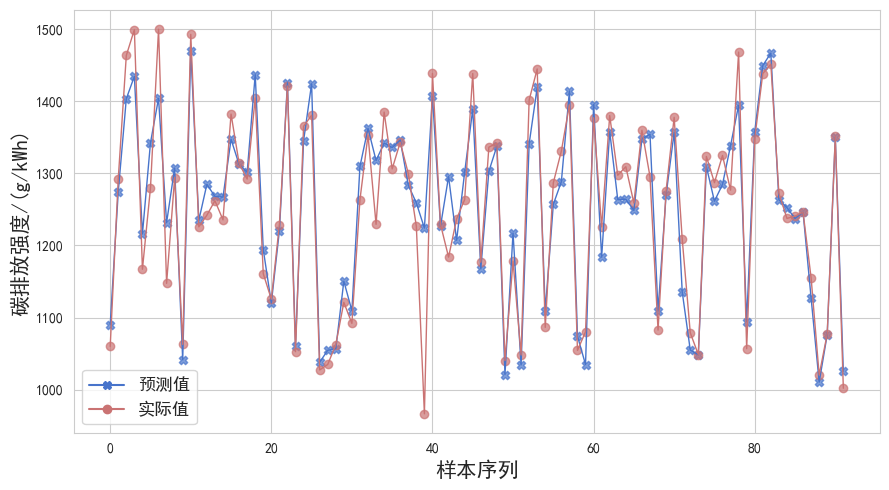

In [30]:
plot_compare(svm_y_pred)

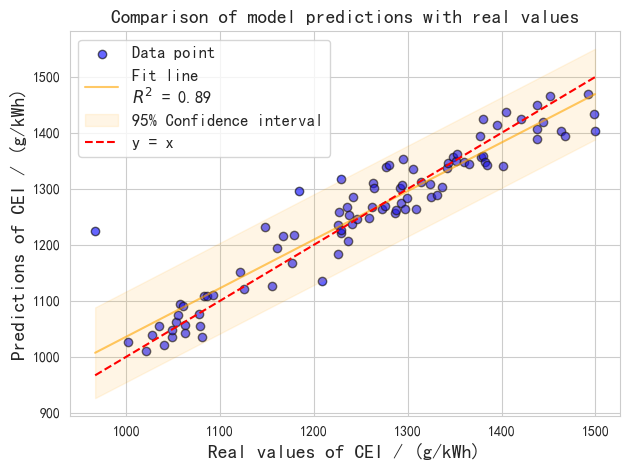

In [31]:
plot_compare_line(svm_y_pred)

C:\Users\97112\AppData\Local\Temp\ipykernel_3124\3741703826.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_correlations = correlations[sorted_idx]  # 排序后的相关性


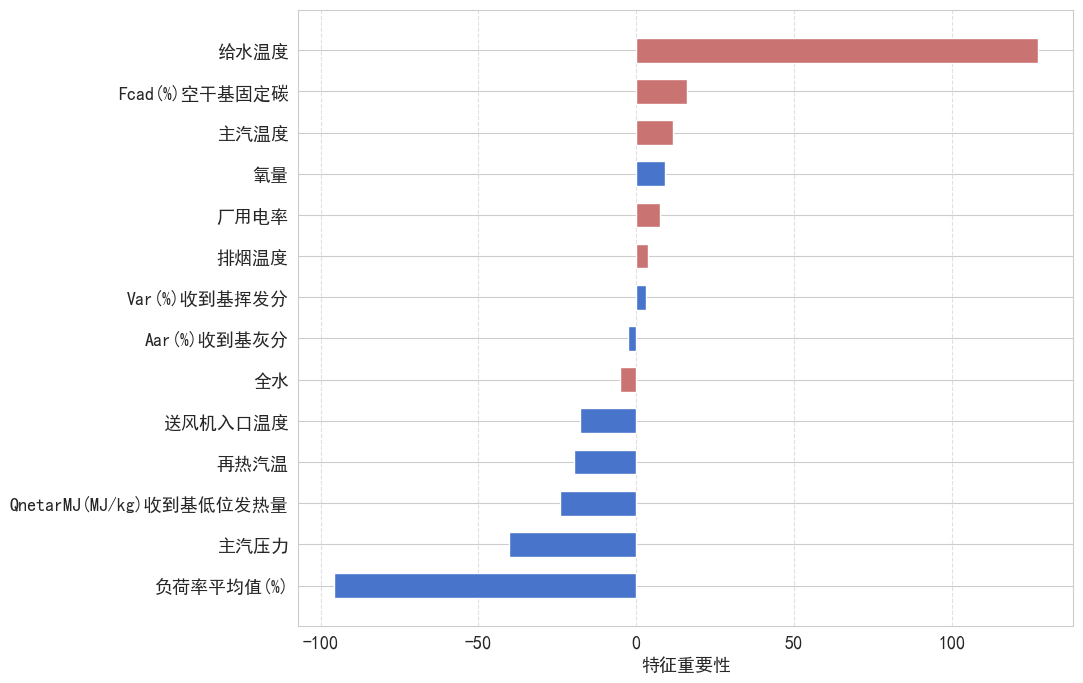

In [13]:
# Extract feature importance (for linear kernel)
feature_importance = svr_model.coef_.flatten()
feature_names = X1.columns
correlation_matrix = df.drop('日期', axis=1).drop('机组', axis=1).corr()#除日期、机组列
correlations =correlation_matrix['碳排放强度'].drop('碳排放强度')
sorted_idx = np.argsort(feature_importance)  # 获取按重要性排序的索引
sorted_feature_names = np.array(feature_names)[sorted_idx]  # 排序后的特征名
sorted_feature_importances = feature_importance[sorted_idx]  # 排序后的特征重要性
sorted_correlations = correlations[sorted_idx]  # 排序后的相关性
# 可视化特征重要性和正反相关性
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances,height = 0.6,
                color=np.where(sorted_correlations > 0, '#CA7373', '#4874CB'))

# 设置y轴标签的字体粗细
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("特征重要性", fontsize=13, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.savefig("feature.png",dpi=1200,bbox_inches='tight')
plt.show()

Using 367 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/92 [00:00<?, ?it/s]

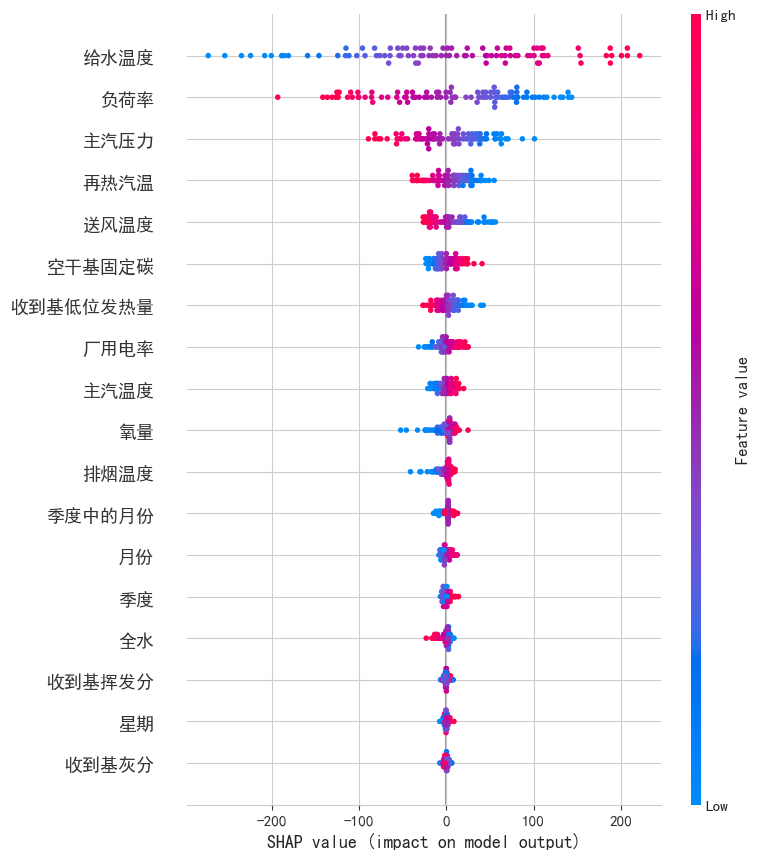

In [15]:
import shap
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# Use the trained SVR model to create an explainer
explainer = shap.KernelExplainer(svr_model.predict, svm_X_train)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(svm_X_test)
# Visualize feature importance using SHAP
shap.summary_plot(shap_values, svm_X_test, feature_names=svm_X.columns)


In [16]:
df.columns

Index(['日期', '机组', '主汽温度', '主汽压力', '氧量', '排烟温度', '送风机入口温度', '再热汽温', '给水温度',
       '全水', 'Aar(%)收到基灰分', 'Var(%)收到基挥发分', 'Fcad(%)空干基固定碳',
       'QnetarMJ(MJ/kg)收到基低位发热量', '厂用电率', '负荷率平均值(%)', '碳排放强度'],
      dtype='object')

ValueError: Contour levels must be increasing

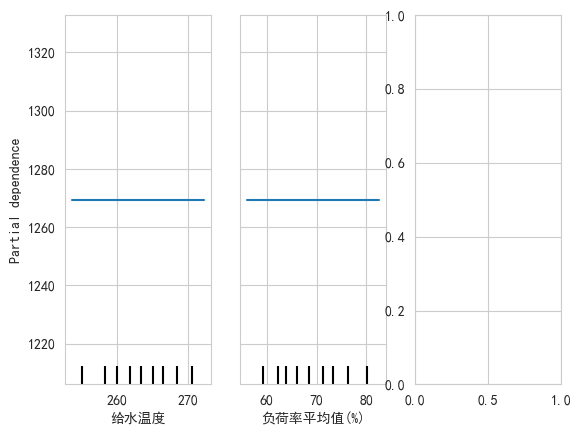

In [24]:
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings("ignore")
t2_features3 = ['给水温度', '负荷率平均值(%)',('给水温度','负荷率平均值(%)' )]
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# 生成双向部分依赖图
disp = PartialDependenceDisplay.from_estimator(svr_model, X1[0:300], t2_features3)

disp.axes_.ravel()[0].set_ylabel('偏依赖量/(g/kWh)', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
disp.axes_.ravel()[2].set_ylabel('A', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
disp.axes_.ravel()[0].set_xlabel('B', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
disp.axes_.ravel()[1].set_xlabel('A', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
disp.axes_.ravel()[2].set_xlabel('B', fontsize=13, fontweight='bold')  # Set y-axis label and make it bold
plt.subplots_adjust(wspace=0.7)

# Save the plot to an image file
#plt.savefig('partial_dependence_plot3.png', dpi=1000, bbox_inches='tight')  # Save as PNG with 500 dpi
plt.show()

## 3.4 ANN

In [26]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random
import torch
import torch.nn as nn
import torch.optim as optim
device='cuda:0' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
# 数据标准化
scaler2 = StandardScaler()
scaler3 = StandardScaler()
X1_train_scaled=scaler2.fit_transform(X1_train)
y1_train_scaled=scaler2.fit_transform(y1_train.to_frame())
X1_test_scaled=scaler3.fit_transform(X1_test)
y1_test_scaled=scaler3.fit_transform(y1_test.to_frame())
# 转为Tensor
X1_train_tensor=torch.FloatTensor(X1_train_scaled).to(device)
y1_train_tensor=torch.FloatTensor(y1_train_scaled).view(-1,1).to(device)
X1_test_tensor=torch.FloatTensor(X1_test_scaled).to(device)
y1_test_tensor=torch.FloatTensor(y1_test_scaled).view(-1,1).to(device)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # 第一个隐藏层
        self.fc2 = nn.Linear(64, 32)          # 第二个隐藏层
        self.fc3 = nn.Linear(32, 1)           # 输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型
input_size = X1_train.shape[1]
model = SimpleNN(input_size).to(device)
# 3. 定义损失函数和优化器
criterion = nn.MSELoss().to(device)  # 均方误差损失
optimizer = optim.SGD(model.parameters(), lr=0.02)

# 4. 训练模型
num_epochs = 1400
for epoch in range(num_epochs):
    model.train()  # 设定训练模式
    optimizer.zero_grad()  # 梯度清零
    outputs = model(X1_train_tensor)  # 前向传播
    loss = criterion(outputs, y1_train_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. 评估模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    predictions = model(X1_test_tensor)  # 预测
    test_loss = criterion(predictions, y1_test_tensor)  # 计算测试损失
    print(f'Test Loss: {test_loss.item():.4f}')

predictions=predictions.cpu().numpy().flatten()
predictions=scaler3.inverse_transform(pd.DataFrame({'pred':predictions}))
# Evaluate the model
dnn_mse = mean_squared_error(y1_test, predictions)
dnn_rmse = np.sqrt(dnn_mse)  # Calculating RMSE
dnn_mae = mean_absolute_error(y1_test, predictions)
dnn_mape = mean_absolute_percentage_error(y1_test, predictions)
dnn_r2 = r2_score(y1_test, predictions)
print(f"dnn_MSE: {dnn_mse:.6f}")
print(f"dnn_RMSE: {dnn_rmse:.6f}")
print(f"dnn_MAE: {dnn_mae:.6f}")
print(f"dnn_MAPE: {dnn_mape*100:.6f}")
print(f"dnn_R Square: {dnn_r2:.6f}")

Epoch [1000/1400], Loss: 0.0533
Test Loss: 0.1347
dnn_MSE: 2452.306038
dnn_RMSE: 49.520764
dnn_MAE: 35.543754
dnn_MAPE: 2.915187
dnn_R Square: 0.865299


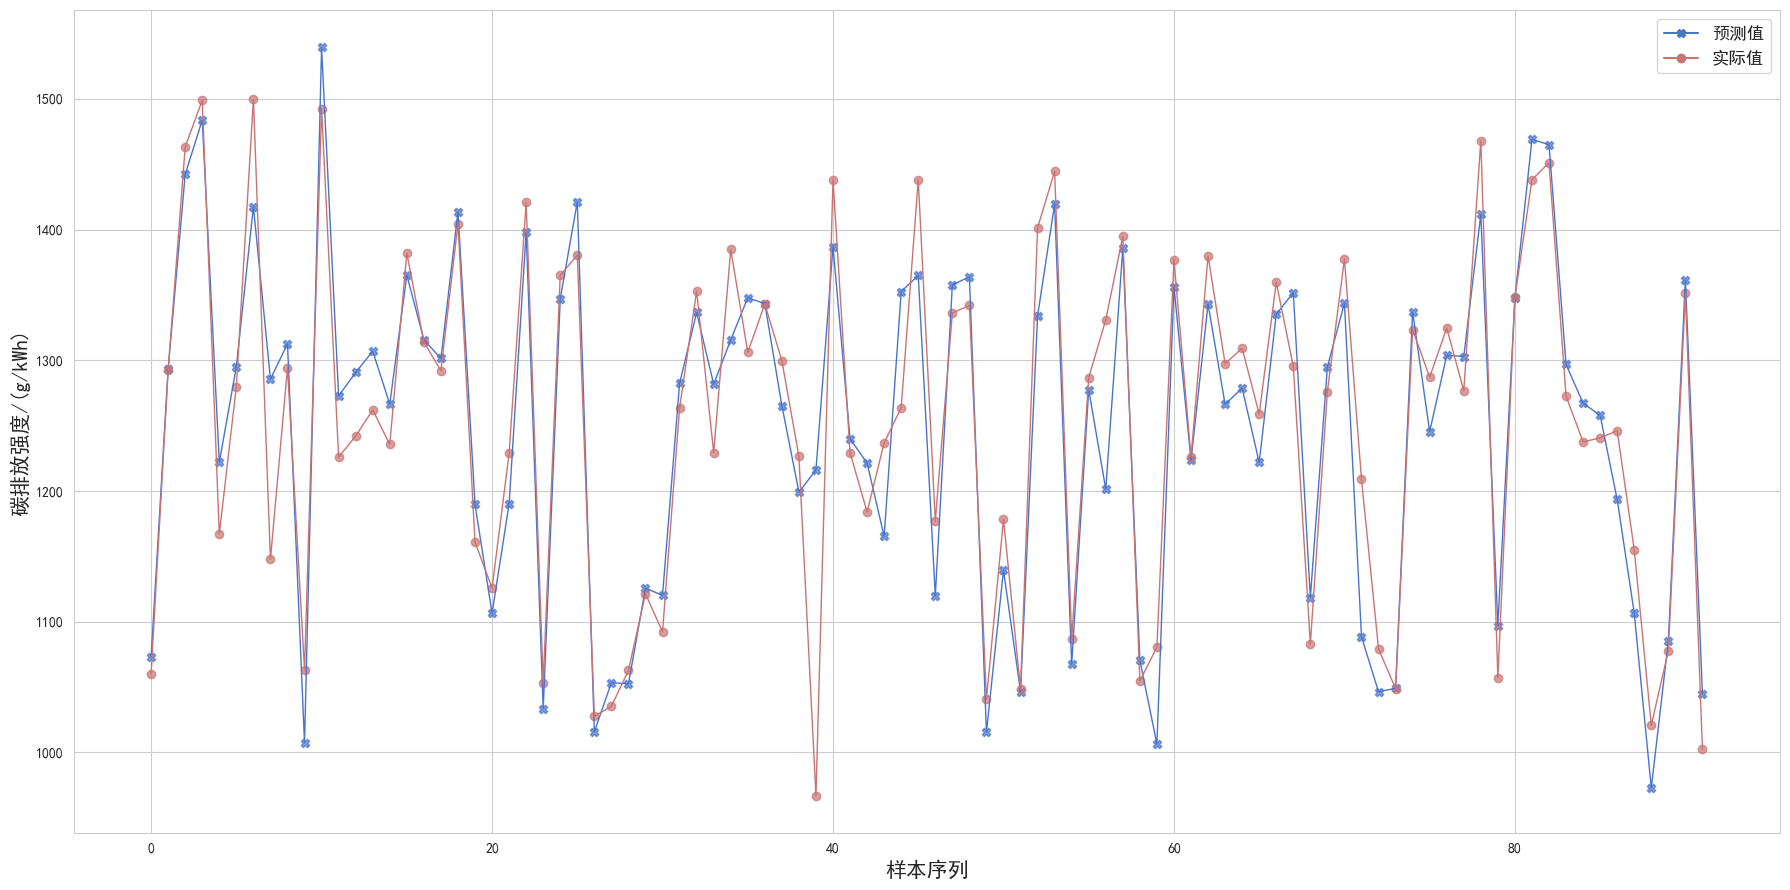

In [27]:
import matplotlib.lines as mlines  # 导入 mlines
# 绘制test data预测值和真实值
plt.figure(figsize=(18, 9))
plt.plot(predictions, label='预测值', linewidth=1,color = "#4874CB")       # 添加预测值的标签
plt.plot(y1_test.values, label='实际值', linewidth=1, color='#CA7373')  # 添加真实值的标签
# 绘制test data的预测值和真实值
plt.scatter(range(len(predictions)), predictions, label='预测值',  alpha=0.7,marker= "X",color = "#4874CB")  # 绘制预测值的散点图
plt.scatter(range(len(y1_test.values)), y1_test.values, label='实际值', alpha=0.7, color='#CA7373')  # 绘制真实值的散点图
# 创建自定义的图例（线+点）
line1 = mlines.Line2D([], [], color="#4874CB", marker="X", markersize=6, label="预测值")
line2 = mlines.Line2D([], [], color="#CA7373", marker="o", markersize=6, label="实际值")

# 显示图例
plt.legend(handles=[line1, line2], fontsize=12.5)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("xgb1.png",dpi=500,bbox_inches='tight')
plt.show()

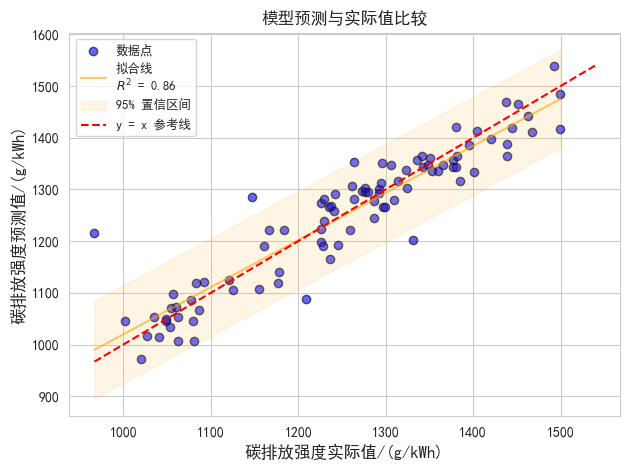

In [45]:
plot_compare_line(predictions.T[0])

## 3.4 LSTM

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 设置TensorFlow使用第一个GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # 还可以设置GPU内存增长，以避免一次性分配所有GPU内存
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)  # 这通常意味着GPU已经被其他进程占用
else:
    print("GPU is not available. Using CPU instead.")
    
# 设置随机种子
# seed_value = 1
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

data = df
# Convert the date column to datetime
data['日期'] = pd.to_datetime(data['日期'])

# Fill missing values with the mean of the column
# data = data.fillna(data.mean())

# Select features and target
features = data.drop(columns=['碳排放强度', '日期','机组'])
target = data['碳排放强度']

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Reshape for LSTM: (samples, time steps, features)
X = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))
y = scaled_target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)
#500 32 225 16
# Make predictions
lstm_y_pred = model.predict(X_test)

# 评估模型
lstm_mse = mean_squared_error(y_test, lstm_y_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test, lstm_y_pred)
lstm_mape = mean_absolute_percentage_error(y_test, lstm_y_pred)
lstm_r2 = r2_score(y_test, lstm_y_pred)

# Plotting predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='实际')
plt.plot(lstm_y_pred, label='预测')
plt.title('LSTM测试集碳排放强度预测值vs实际值')
plt.xlabel('时间')
plt.ylabel('碳排放强度',fontsize = 11)
plt.legend()
plt.show()
print(f"LSTM_MSE: {lstm_mse:.6f}")
print(f"LSTM_RMSE: {lstm_rmse:.6f}")
print(f"LSTM_MAE: {lstm_mae:.6f}")
print(f"LSTM_MAPE: {lstm_mape*100:.6f}")
print(f"LSTM_R Square: {lstm_r2:.6f}")

#rescale
lstm_y_pred_rescaled = scaler.inverse_transform(lstm_y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# 计算真实尺度上的MSE、RMSE、MAE等
lstm_mse2 = mean_squared_error(y_test_rescaled, lstm_y_pred_rescaled)
lstm_rmse2 = np.sqrt(lstm_mse2)
lstm_mae2 = mean_absolute_error(y_test_rescaled, lstm_y_pred_rescaled)
lstm_mape2 = mean_absolute_percentage_error(y_test_rescaled, lstm_y_pred_rescaled)
lstm_r22 = r2_score(y_test_rescaled, lstm_y_pred_rescaled)

print(f"LSTM_MSE: {lstm_mse2:.6f}")
print(f"LSTM_RMSE: {lstm_rmse2:.6f}")
print(f"LSTM_MAE: {lstm_mae2:.6f}")
print(f"LSTM_MAPE: {lstm_mape2*100:.6f}")
print(f"LSTM_R Square: {lstm_r22:.6f}")

model.predict(X_test)

# Plotting predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(lstm_y_pred_rescaled, label='预测值')
plt.plot(y_test_rescaled, label='实际值')
# plt.title('LSTM测试集碳排放强度预测值vs实际值')
# 显示图例
plt.legend(fontsize=15)
plt.xlabel("样本序列",fontsize = 15,fontweight='bold')
plt.ylabel("碳排放强度/(g/kWh)",fontsize = 15,fontweight='bold')

# 显示图表
plt.tight_layout()  # 调整布局，确保所有元素不重叠
# plt.savefig("lstm.png",dpi=500,bbox_inches='tight')
plt.show()